# Let's see if discounts take place often

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Load data
train_df = pd.read_csv("../sales_train.csv.gz")
test_df  = pd.read_csv("../test.csv.gz")

categories = pd.read_csv('../item_categories.csv')
items = pd.read_csv('../items.csv')
shops = pd.read_csv('../shops.csv')

In [2]:
%store -r __prepare_data_4

In [3]:
%%time
__prepare_data_4

CPU times: user 3min 4s, sys: 1min 55s, total: 4min 59s
Wall time: 5min 14s


In [4]:
# based on tables from 2019.11.16/trends_combined.ipynb I choose those shops to be taken out:
closed_shops = [0, 1, 8, 9, 11, 13, 17, 20, 23,  27,  29, 30, 32, 33,  36,  40, 43, 54]

biggest_shops = [31, 25, 42, 55, 12, 22, 26, 28 ,36]

# one of those, though, needs to be predicted (#36):
print(test_df[test_df.shop_id.isin(closed_shops)].shop_id.unique())

# and one of shops (#51) does not (keep it for training anyways):
print(set(all_data.shop_id.unique()).difference(test_df.shop_id.unique()))

# this explains why shop #36 is not a good shop:
(all_data[all_data.shop_id == 36]
             .groupby(["date_block_num"])
             .agg({'total_monthly_shop_sales': lambda x: np.NA if x.empty else x.iloc[0]})
             .reset_index())

[36]
{0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54}


,date_block_num,total_monthly_shop_sales
0,33,0.060964
1,34,0.000000


In [15]:
for shop in all_data.shop_id.unique():
    if shop in closed_shops:
        continue
    shop_data = all_data[all_data.shop_id==shop]
    items = set(test_df.item_id.unique()).intersection(set(shop_data.item_id))
    print("shop #%d: %d" % (shop,len(items)))

shop #2: 5100
shop #3: 5100
shop #4: 5100
shop #6: 5100
shop #7: 5100
shop #10: 5100
shop #12: 5100
shop #14: 5100
shop #15: 5100
shop #16: 5100
shop #18: 5100
shop #19: 5100
shop #21: 5100
shop #22: 5100
shop #24: 5100
shop #25: 5100
shop #26: 5100
shop #28: 5100
shop #31: 5100
shop #35: 5100
shop #37: 5100
shop #38: 5100
shop #41: 5100
shop #42: 5100
shop #44: 5100
shop #45: 5100
shop #46: 5100
shop #47: 5100
shop #50: 5100
shop #51: 4454
shop #52: 5100
shop #53: 5100
shop #56: 5100
shop #59: 5100
shop #5: 5100
shop #57: 5100
shop #58: 5100
shop #55: 5100
shop #49: 5100
shop #39: 5100
shop #48: 5100
shop #34: 5100


In [11]:
train_df[(train_df.item_id==30) & (train_df.shop_id==5)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
164314,25.02.2013,1,5,30,399.0,1.0
164315,18.02.2013,1,5,30,399.0,1.0
164316,16.02.2013,1,5,30,399.0,1.0
164322,21.02.2013,1,5,30,399.0,2.0
345368,03.03.2013,2,5,30,399.0,2.0
345369,08.03.2013,2,5,30,399.0,1.0
345370,10.03.2013,2,5,30,399.0,1.0
345371,15.03.2013,2,5,30,399.0,1.0
345372,17.03.2013,2,5,30,399.0,1.0
345373,31.03.2013,2,5,30,399.0,1.0


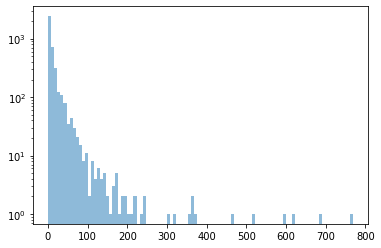

CPU times: user 1.43 s, sys: 442 ms, total: 1.87 s
Wall time: 1.99 s


In [45]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline

item_sales = all_data.groupby(["date_block_num","item_id"]).agg({"target":sum}).reset_index()

item_sales = item_sales[item_sales.item_id.isin(test_df.item_id.unique())]

plt.hist(item_sales[item_sales.date_block_num==33].target, bins=100, alpha=0.5)
plt.yscale('log')
plt.show()

best_sellers = item_sales[item_sales.target>900].item_id.unique()

4


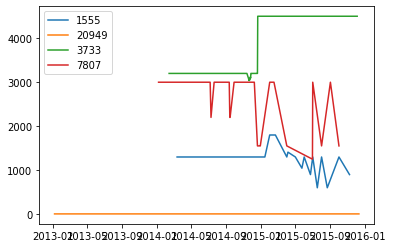

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_shop = pd.DataFrame()

for shop in [6]: #all_data.shop_id.unique():

    if shop in closed_shops:
        continue

    shop_data = train_df[train_df.shop_id==shop]

    items = set(test_df.item_id.unique()).intersection(set(shop_data.item_id))

    items = items.intersection(set(best_sellers))
    print(len(items))

    for item in items:
        data = train_df[(train_df.shop_id==shop) & (train_df.item_id==item)].copy(deep=True)
        data["date"] = pd.to_datetime(data.date)
        data.sort_values(["date"], inplace=True)

        plt.plot(data.date, data.item_price.values, label=item)

plt.legend(loc='best')

In [64]:
train_df[(train_df.shop_id==5) & (train_df.item_id==3733)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2150745,19.11.2014,22,5,3733,3050.707317,41.0
2150780,20.11.2014,22,5,3733,3071.000000,5.0
2150781,21.11.2014,22,5,3733,3039.000000,1.0
2150782,22.11.2014,22,5,3733,3039.000000,3.0
2150783,23.11.2014,22,5,3733,3039.000000,2.0
2150784,24.11.2014,22,5,3733,3199.000000,2.0
2150785,25.11.2014,22,5,3733,3199.000000,2.0
2150786,26.11.2014,22,5,3733,3199.000000,1.0
2150787,27.11.2014,22,5,3733,3199.000000,1.0
2289079,27.12.2014,23,5,3733,4499.000000,2.0
